## Hierarchical LSTM Model for Position Estimation

### Load packages

In [1]:
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import os
import pickle
import keras
from keras.layers import *
from keras.models import *
import IPython.display as ipyd
plt.style.use('ggplot')


Using TensorFlow backend.


### Define distance functions

In [2]:
#define 1D and 2D distance function
def distance2(p0,p1):
    
    return ((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def distance(p0,p1):
    
    return ((p0 - p1)**2)


### Load data 

In [3]:
# import data
PlaceCell=43
path2='Data33.mat'
mat=spio.loadmat(path2,squeeze_me=True)
x_data=mat['MSTrain'][:,1:63].astype('float32')
y_data=mat['MSTrain'][:,63:67].astype('float32')
# Calculate Min and max 
y_data2=np.zeros((y_data.shape))
MinX=np.min(y_data[:,0],axis=0)
MinY=np.min(y_data[:,1],axis=0)
MaxX=np.max(y_data[:,0],axis=0)
MaxY=np.max(y_data[:,1],axis=0)

VMinX=np.min(y_data[:,2],axis=0)
VMinY=np.min(y_data[:,3],axis=0)
VMaxX=np.max(y_data[:,2],axis=0)
VMaxY=np.max(y_data[:,3],axis=0)


NT=np.floor(x_data.shape[0]*.15).astype('int32') ## Number Of Test
NTr=np.floor(x_data.shape[0]*.85).astype('int32')
Patch=5000
#Generate data for maze classification section
y_data2[:NTr,0]=np.divide(y_data[:NTr,0]-MinX,MaxX-MinX)
y_data2[:NTr,1]=np.divide(y_data[:NTr,1]-MinY,MaxY-MinY)
y_data2[:NTr,2]=np.divide(y_data[:NTr,2]-VMinX,VMaxX-VMinX)
y_data2[:NTr,3]=np.divide(y_data[:NTr,3]-VMinY,VMaxY-VMinY)

ArmInd=np.zeros((x_data.shape[0],4))
y=y_data
for i in range(x_data.shape[0]):
    if y[i,0] >= 165 and y[i,0] <= 200 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,0]=1
    elif y[i,0] > 200 and y[i,0] <= 240 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,1]=1
    elif y[i,0] > 240 and y[i,0] <= 265 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,2]=1
    else:
        ArmInd[i,3]=1

x_data[x_data ==0]=-1

### Create training and test data
Arm_train=np.zeros((np.int32(np.floor(NTr/Patch)),Patch,4))
X_train=np.zeros((np.int32(np.floor(NTr/Patch)),Patch,62))
y_train=np.zeros((np.int32(np.floor(NTr/Patch)),Patch,4))

## Create Train and Test Set

Arm_train=ArmInd[:NTr,:].reshape(1,NTr,4)
X_train=x_data[:NTr,:].reshape(1,NTr,62)
y_train=y_data2[:NTr,:].reshape(1,NTr,4)
X_test=x_data[y_data.shape[0]-NT:].reshape(1,NT,62)
Arm_test=ArmInd[y_data.shape[0]-NT:].reshape(1,NT,4)

y_test=y_data[y_data.shape[0]-NT:].reshape(1,NT,4)

print ('Train dataX shape: ', X_train.shape)
print ('Train dataA shape: ', Arm_train.shape)
print ('train dataY shape: ', y_train.shape)

print ('Test dataX shape: ', X_test.shape)
print ('Test dataA shape: ', Arm_test.shape)
print ('Test dataY shape: ', y_test.shape)


Train dataX shape:  (1, 23209, 62)
Train dataA shape:  (1, 23209, 4)
train dataY shape:  (1, 23209, 4)
Test dataX shape:  (1, 4095, 62)
Test dataA shape:  (1, 4095, 4)
Test dataY shape:  (1, 4095, 4)


### Create Position Estimator with penalized loss

The Below Figure describes the hierarchical LSTM model.




<img src='Img1.png'>

#### Build the Model in Keras

In [4]:
import keras.backend as K

# Define cost function for bouth positions
def penalized_loss(Pen):
    Pen1=(K.abs(Pen-0.5)+.1)*2
    def loss(y_true, y_pred):
     
        return K.mean(K.square(y_pred - y_true)*Pen1 , axis=-1)
    return loss

# Create position estimator model
In=Input(shape=(X_train.shape[1:]),name='Input')
Maze=LSTM(4,return_sequences=True,name='MazeSeq')(In)
Ve=LSTM(2,return_sequences=True,name='VelocitySeq')(In)
V=TimeDistributed(Dense(2,activation='sigmoid'),name='Velocity')(Ve)
M=concatenate([Maze,In,Ve],name='ConcatFeature')
Pe=LSTM(2,return_sequences=True,name='PositionSeq')(M)
Maze=TimeDistributed(Dense(4,activation='softmax'),name='Maze')(Maze)
P=TimeDistributed(Dense(2,activation='sigmoid'),name='Position')(Pe)
Model2=Model(inputs=In,outputs=[P,V,Maze])



Model2.compile(loss={'Velocity':'mse','Position':penalized_loss(V),'Maze':'binary_crossentropy'},
            optimizer='rmsprop',metrics={'Maze':'accuracy'})



# Create summary of model
Model2.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 23209, 62)     0                                            
____________________________________________________________________________________________________
MazeSeq (LSTM)                   (None, 23209, 4)      1072        Input[0][0]                      
____________________________________________________________________________________________________
VelocitySeq (LSTM)               (None, 23209, 2)      520         Input[0][0]                      
____________________________________________________________________________________________________
ConcatFeature (Concatenate)      (None, 23209, 68)     0           MazeSeq[0][0]                    
                                                                   Input[0][0]             

### Train the Model

In [ ]:
path='PositionEstimatorFull.h5'
Model2.load_weights(path)
#Hist=Model2.fit(X_train,[y_train[:,:,:2],y_train[:,:,2:],Arm_train],shuffle=False,epochs=400,verbose=1,batch_size=1)
Model2.save_weights(path)



### Load Trained Model

In [6]:
import keras.backend as K

# Define cost function for bouth positions
def penalized_loss(Pen):
    Pen1=(K.abs(Pen-0.5))*2
    def loss(y_true, y_pred):
     
        return K.mean(K.square(y_pred - y_true)*Pen1 , axis=-1)
    return loss

# Create position estimator model
In=Input(shape=(X_test.shape[1:]),name='Input')
Maze=LSTM(4,return_sequences=True,name='MazeSeq')(In)
Ve=LSTM(2,return_sequences=True,name='VelocitySeq')(In)
V=TimeDistributed(Dense(2,activation='sigmoid'),name='Velocity')(Ve)
M=concatenate([Maze,In,Ve],name='ConcatFeature')
Pe=LSTM(2,return_sequences=True,name='PositionSeq')(M)
Maze=TimeDistributed(Dense(4,activation='softmax'),name='Maze')(Maze)
P=TimeDistributed(Dense(2,activation='sigmoid'),name='Position')(Pe)
Model2=Model(inputs=In,outputs=[P,V,Maze])



Model2.compile(loss={'Velocity':'mse','Position':'mse','Maze':'binary_crossentropy'},
            optimizer='rmsprop',metrics={'Maze':'accuracy'})


# Create summary of model
Model2.summary()


path='PositionEstimatorFull.h5'
Model2.load_weights(path)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 4095, 62)      0                                            
____________________________________________________________________________________________________
MazeSeq (LSTM)                   (None, 4095, 4)       1072        Input[0][0]                      
____________________________________________________________________________________________________
VelocitySeq (LSTM)               (None, 4095, 2)       520         Input[0][0]                      
____________________________________________________________________________________________________
ConcatFeature (Concatenate)      (None, 4095, 68)      0           MazeSeq[0][0]                    
                                                                   Input[0][0]             

### Test Session

test time=0.747753
RMSE Estmation X=5.017596
RMSE Estmation Y=7.087223
2D Distance=8.683606
RMSE Estmation VX=6.484363
RMSE Estmation VY=9.782359
2D Distance Velocity=11.736333


Text(0.5,1,'Estimate Velocity Y RMSE=9.782359')

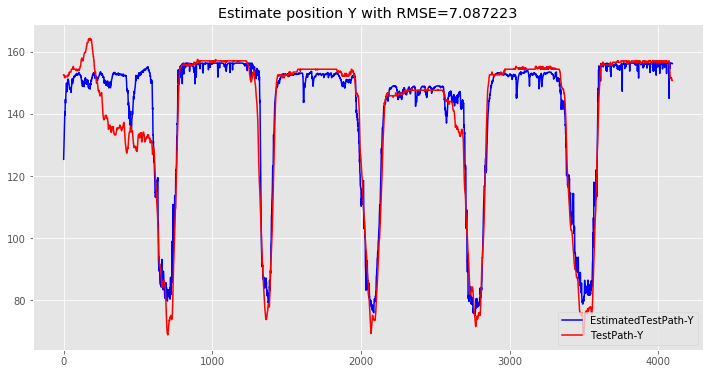

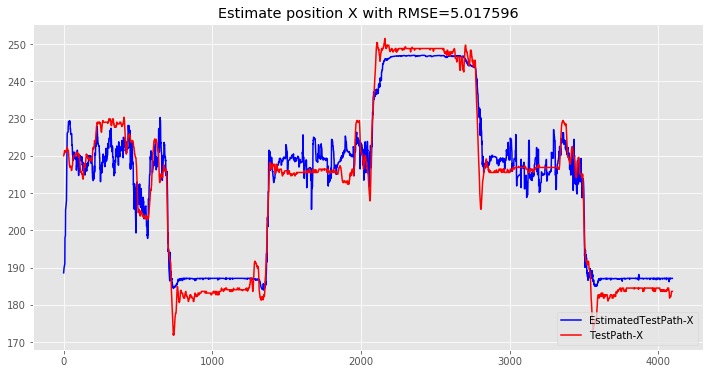

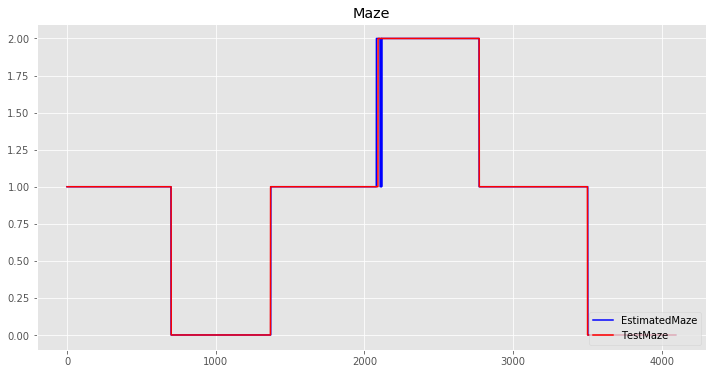

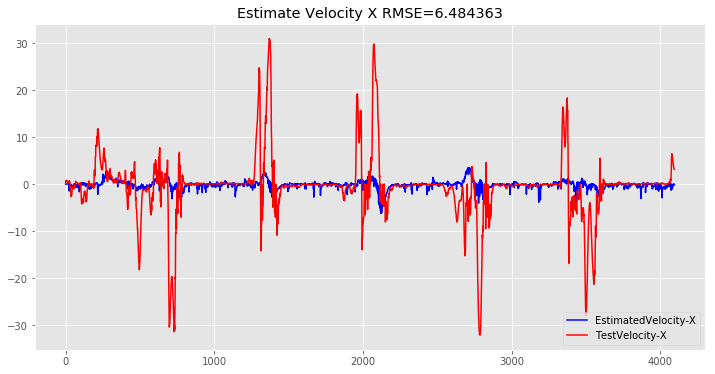

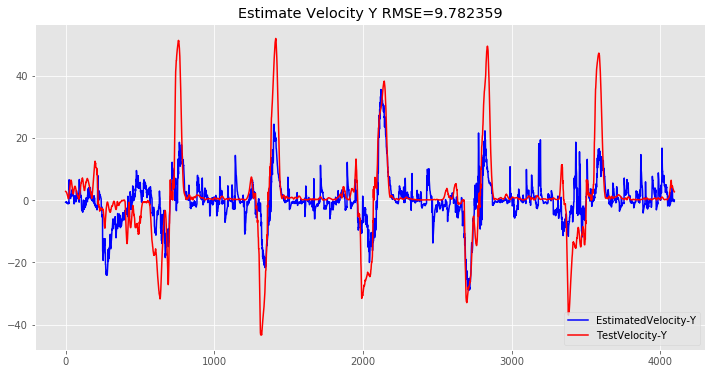

In [8]:
import timeit

y_predict=np.zeros((y_test.shape[1],2))
start = timeit.default_timer()

[y_valid_predicted_lstm,Vs,Maze]=Model2.predict(X_test)

y_predict[:,0]=np.multiply(y_valid_predicted_lstm[0,:,0],MaxX-MinX)+MinX
y_predict[:,1]=np.multiply(y_valid_predicted_lstm[0,:,1],MaxY-MinY)+MinY

Vs[0,:,0]=np.multiply(Vs[0,:,0],VMaxX-VMinX)+VMinX
Vs[0,:,1]=np.multiply(Vs[0,:,1],VMaxY-VMinY)+VMinY

### Analyze position estimator estimator
stop = timeit.default_timer()

print('test time=%f'% (stop - start) )
### calculate RMSE and 2d distance for X,Y Test path

rmsX=np.zeros(y_test.shape[1])
rmsY=np.zeros(y_test.shape[1])
a=np.zeros(y_test.shape[1])
for i in range(y_test.shape[1]):
    rmsX[i] = np.mean(distance(y_test[0,i,0], y_predict[i,0]))
    rmsY[i] = np.mean(distance(y_test[0,i,1], y_predict[i,1]))
    a[i]=distance2(y_test[0,i,:2], y_predict[i,:2])
rmsX=np.sqrt(np.mean(rmsX))
rmsY=np.sqrt(np.mean(rmsY))
b=np.sqrt(np.mean(a))
print('RMSE Estmation X=%f'%rmsX)

print('RMSE Estmation Y=%f'%rmsY)
print('2D Distance=%f'%b)
### plot and save predictions

plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predict[:,1],'b',label="EstimatedTestPath-Y")


plt.plot(y_test[0,:,1],'r',label="TestPath-Y")
#plt.plot(np.multiply(y_train[0,:,1],MaxY-MinY)+MinY,'y',label="TrainPath-Y")
plt.legend(loc=4)
plt.title('Estimate position Y with RMSE=%f'%rmsY)
#plt.savefig('EstimatedTestPath-Y2.png',format='png', dpi=1000,transparent=False)
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predict[:,0],'b',label="EstimatedTestPath-X")


plt.plot(y_test[0,:,0],'r',label="TestPath-X")
#plt.plot(np.multiply(y_train[0,:,0],MaxX-MinX)+MinX,'y',label="TrainPath-X")
plt.legend(loc=4)
plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure

#plt.savefig('EstimatedTestPath-X2.png',format='png', dpi=1000,transparent=False)



plt.figure(num=None, figsize=(12, 6))
plt.plot(np.argmax(Maze[0],axis=-1),'b',label="EstimatedMaze")
plt.plot(np.argmax(Arm_test[0],axis=-1),'r',label="TestMaze")
plt.legend(loc=4)
plt.title('Maze')
VrmsX=np.zeros(y_test.shape[1])
VrmsY=np.zeros(y_test.shape[1])
Va=np.zeros(y_test.shape[1])
for i in range(y_test.shape[1]):
    VrmsX[i] = np.mean(distance(y_test[0,i,2], Vs[0,i,0]))
    VrmsY[i] = np.mean(distance(y_test[0,i,3], Vs[0,i,1]))
    Va[i]=distance2(y_test[0,i,2:], Vs[0,i,:2])
VrmsX=np.sqrt(np.mean(VrmsX))
VrmsY=np.sqrt(np.mean(VrmsY))
Vb=np.sqrt(np.mean(Va))
print('RMSE Estmation VX=%f'%VrmsX)

print('RMSE Estmation VY=%f'%VrmsY)
print('2D Distance Velocity=%f'%Vb)
#plt.savefig('EstimatedTestPath-X2.png',format='png', dpi=1000,transparent=False)
plt.figure(num=None, figsize=(12, 6))
plt1=plt.plot(Vs[0,:,0],'b',label="EstimatedVelocity-X")
plt.plot(y_test[0,:,2],'r',label="TestVelocity-X")
plt.legend(loc=4)
plt.title('Estimate Velocity X RMSE=%f'%VrmsX)
#
plt.figure(num=None, figsize=(12, 6))
plt1=plt.plot(Vs[0,:,1],'b',label="EstimatedVelocity-Y")
plt.plot(y_test[0,:,3],'r',label="TestVelocity-Y")
plt.legend(loc=4)
plt.title('Estimate Velocity Y RMSE=%f'%VrmsY)